<a href="https://colab.research.google.com/github/johncoogan53/HW5/blob/main/HWK5_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 5: Adversarial Attacks and Defenses

Duke University

ECE661 Fall 2024

## Setup

You shouldn't have to change anything in these cells

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import sys
import os
google_drive_path = '/content/drive/My Drive/HW5'
sys.path.append(google_drive_path)
os.chdir(google_drive_path)

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import random

# Custom
import models
import attacks

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

device: cuda


In [5]:
train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('./data', train=True, download=True, transform=transforms.ToTensor()),
    batch_size = 64, shuffle=True, )
test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('./data', train=False, download=True, transform=transforms.ToTensor()),
    batch_size = 64, shuffle=False, )

In [6]:
def test_model(mdl, loader, device):
    mdl.eval()
    running_correct = 0.
    running_loss = 0.
    running_total = 0.
    with torch.no_grad():
        for batch_idx,(data,labels) in enumerate(loader):
            data = data.to(device); labels = labels.to(device)
            clean_outputs = mdl(data)
            clean_loss = F.cross_entropy(clean_outputs, labels)
            _,clean_preds = clean_outputs.max(1)
            running_correct += clean_preds.eq(labels).sum().item()
            running_loss += clean_loss.item()
            running_total += labels.size(0)
    clean_acc = running_correct/running_total
    clean_loss = running_loss/len(loader)
    mdl.train()
    return clean_acc,clean_loss

## Model training

Train a model and save the checkpoint. This cell is used in Lab-1 and Lab-3

## Net A

In [68]:
## Pick a model architecture
net = models.NetA().to(device)
#net = models.NetB().to(device)

## Checkpoint name for this model
model_checkpoint = "netA_advtrain_pgd0p1.pt"
#model_checkpoint = "netB_standard.pt"

## Basic training params
num_epochs = 20
initial_lr = 0.001
lr_decay_epoch = 15

optimizer = torch.optim.Adam(net.parameters(), lr=initial_lr)

## Training Loop
for epoch in range(num_epochs):
    net.train()
    train_correct = 0.
    train_loss = 0.
    train_total = 0.
    for batch_idx,(data,labels) in enumerate(train_loader):
        eps = 0.1
        perturb_iters = 4
        alpha = 1.85* (eps/perturb_iters)
        adv_data = attacks.PGD_attack(net,device,data.clone().detach().to(device),labels.to(device),eps=0.1,alpha=alpha,iters=perturb_iters,rand_start=False)
        data = data.to(device); labels = labels.to(device)
        data = torch.cat((data,adv_data),0);labels = torch.cat((labels,labels),0)

        # Forward pass
        outputs = net(data)
        net.zero_grad()
        optimizer.zero_grad()
        # Compute loss, gradients, and update params
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        # Update stats
        _,preds = outputs.max(1)
        train_correct += preds.eq(labels).sum().item()
        train_loss += loss.item()
        train_total += labels.size(0)

    # End of training epoch
    test_acc,test_loss = test_model(net,test_loader,device)
    print("Epoch: [ {} / {} ]; TrainAcc: {:.5f}; TrainLoss: {:.5f}; TestAcc: {:.5f}; TestLoss: {:.5f}".format(
        epoch, num_epochs, train_correct/train_total, train_loss/len(train_loader),
        test_acc, test_loss,
    ))
    # Save model
    torch.save(net.state_dict(), model_checkpoint)

    # Update LR
    if epoch == lr_decay_epoch:
        for param_group in optimizer.param_groups:
            param_group['lr'] = initial_lr*0.1

print("Done!")

Epoch: [ 0 / 20 ]; TrainAcc: 0.71683; TrainLoss: 0.72353; TestAcc: 0.84050; TestLoss: 0.43071
Epoch: [ 1 / 20 ]; TrainAcc: 0.77369; TrainLoss: 0.57199; TestAcc: 0.85530; TestLoss: 0.38650
Epoch: [ 2 / 20 ]; TrainAcc: 0.79177; TrainLoss: 0.52560; TestAcc: 0.86000; TestLoss: 0.37996
Epoch: [ 3 / 20 ]; TrainAcc: 0.80219; TrainLoss: 0.49859; TestAcc: 0.86400; TestLoss: 0.36882
Epoch: [ 4 / 20 ]; TrainAcc: 0.80847; TrainLoss: 0.48115; TestAcc: 0.85750; TestLoss: 0.36382
Epoch: [ 5 / 20 ]; TrainAcc: 0.81389; TrainLoss: 0.46676; TestAcc: 0.86940; TestLoss: 0.34480
Epoch: [ 6 / 20 ]; TrainAcc: 0.81912; TrainLoss: 0.45284; TestAcc: 0.86540; TestLoss: 0.34479
Epoch: [ 7 / 20 ]; TrainAcc: 0.82239; TrainLoss: 0.44347; TestAcc: 0.87220; TestLoss: 0.34290
Epoch: [ 8 / 20 ]; TrainAcc: 0.82739; TrainLoss: 0.43215; TestAcc: 0.86410; TestLoss: 0.34153
Epoch: [ 9 / 20 ]; TrainAcc: 0.82967; TrainLoss: 0.42581; TestAcc: 0.87590; TestLoss: 0.33037
Epoch: [ 10 / 20 ]; TrainAcc: 0.83155; TrainLoss: 0.41996; T

## Net B

In [9]:
## Pick a model architecture
#net = models.NetA().to(device)
net = models.NetB().to(device)

## Checkpoint name for this model
#model_checkpoint = "netA_standard.pt"
model_checkpoint = "netB_standard.pt"

## Basic training params
num_epochs = 20
initial_lr = 0.001
lr_decay_epoch = 15

optimizer = torch.optim.Adam(net.parameters(), lr=initial_lr)

## Training Loop
for epoch in range(num_epochs):
    net.train()
    train_correct = 0.
    train_loss = 0.
    train_total = 0.
    for batch_idx,(data,labels) in enumerate(train_loader):
        data = data.to(device); labels = labels.to(device)

        # Forward pass
        outputs = net(data)
        net.zero_grad()
        optimizer.zero_grad()
        # Compute loss, gradients, and update params
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        # Update stats
        _,preds = outputs.max(1)
        train_correct += preds.eq(labels).sum().item()
        train_loss += loss.item()
        train_total += labels.size(0)

    # End of training epoch
    test_acc,test_loss = test_model(net,test_loader,device)
    print("Epoch: [ {} / {} ]; TrainAcc: {:.5f}; TrainLoss: {:.5f}; TestAcc: {:.5f}; TestLoss: {:.5f}".format(
        epoch, num_epochs, train_correct/train_total, train_loss/len(train_loader),
        test_acc, test_loss,
    ))
    # Save model
    torch.save(net.state_dict(), model_checkpoint)

    # Update LR
    if epoch == lr_decay_epoch:
        for param_group in optimizer.param_groups:
            param_group['lr'] = initial_lr*0.1

print("Done!")

Epoch: [ 0 / 20 ]; TrainAcc: 0.84358; TrainLoss: 0.42626; TestAcc: 0.88560; TestLoss: 0.31773
Epoch: [ 1 / 20 ]; TrainAcc: 0.90468; TrainLoss: 0.26585; TestAcc: 0.90870; TestLoss: 0.25552
Epoch: [ 2 / 20 ]; TrainAcc: 0.91972; TrainLoss: 0.22458; TestAcc: 0.91080; TestLoss: 0.24524
Epoch: [ 3 / 20 ]; TrainAcc: 0.92717; TrainLoss: 0.19959; TestAcc: 0.91310; TestLoss: 0.24565
Epoch: [ 4 / 20 ]; TrainAcc: 0.93428; TrainLoss: 0.17858; TestAcc: 0.90900; TestLoss: 0.25116
Epoch: [ 5 / 20 ]; TrainAcc: 0.94022; TrainLoss: 0.16216; TestAcc: 0.92070; TestLoss: 0.22527
Epoch: [ 6 / 20 ]; TrainAcc: 0.94608; TrainLoss: 0.14621; TestAcc: 0.91700; TestLoss: 0.24270
Epoch: [ 7 / 20 ]; TrainAcc: 0.95257; TrainLoss: 0.12997; TestAcc: 0.91860; TestLoss: 0.24290
Epoch: [ 8 / 20 ]; TrainAcc: 0.95693; TrainLoss: 0.11669; TestAcc: 0.91790; TestLoss: 0.26508
Epoch: [ 9 / 20 ]; TrainAcc: 0.96095; TrainLoss: 0.10552; TestAcc: 0.92020; TestLoss: 0.26627
Epoch: [ 10 / 20 ]; TrainAcc: 0.96473; TrainLoss: 0.09501; T

**Visualize some perturbed samples**

<ipython-input-6-883b76ee1044>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load("netA_standard.pt"))


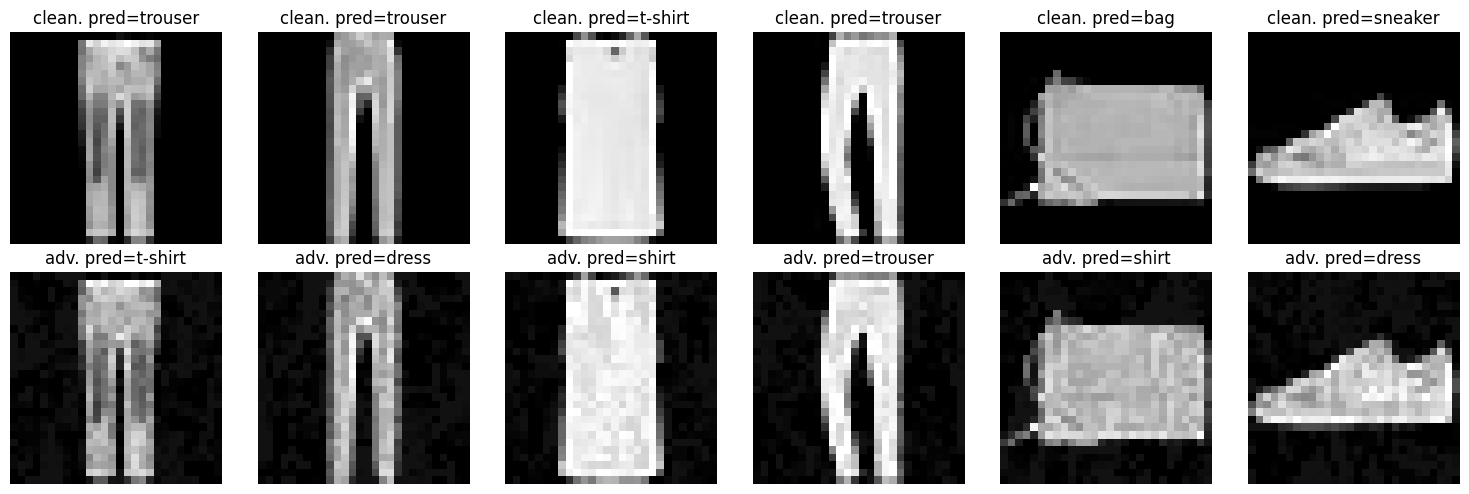

In [ ]:
classes = ["t-shirt", "trouser","pullover","dress","coat","sandal","shirt","sneaker","bag","boot"]
net = models.NetA().to(device)
net.load_state_dict(torch.load("netA_standard.pt"))
for data,labels in test_loader:
        data = data.to(device); labels = labels.to(device)

        ###
        # Compute and apply adversarial perturbation to data
        # eps between 0 and 0.2
        EPS= 0.07
        ITS=10
        ALP = 1.85*(EPS/ITS)

        ###
        adv_data = attacks.PGD_attack(net,device,data.clone().detach(),labels,EPS,ALP,ITS,rand_start=False)
        # Compute preds
        with torch.no_grad():
            clean_outputs = net(data)
            _,clean_preds = clean_outputs.max(1)
            clean_preds = clean_preds.cpu().squeeze().numpy()
            adv_outputs = net(adv_data)
            _,adv_preds = adv_outputs.max(1)
            adv_preds = adv_preds.cpu().squeeze().numpy()

        # Plot some samples
        inds = random.sample(list(range(data.size(0))),6)
        plt.figure(figsize=(15,5))
        for jj in range(6):
            plt.subplot(2,6,jj+1);plt.imshow(data[inds[jj],0].cpu().numpy(),cmap='gray');plt.axis("off");
            plt.title("clean. pred={}".format(classes[clean_preds[inds[jj]]]))
        for jj in range(6):
            plt.subplot(2,6,6+jj+1);plt.imshow(adv_data[inds[jj],0].cpu().numpy(),cmap='gray');plt.axis("off");
            plt.title("adv. pred={}".format(classes[adv_preds[inds[jj]]]))
        plt.tight_layout()
        plt.show()
        break

## FGSM

<ipython-input-7-eb8a63df1cac>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load("netA_standard.pt"))


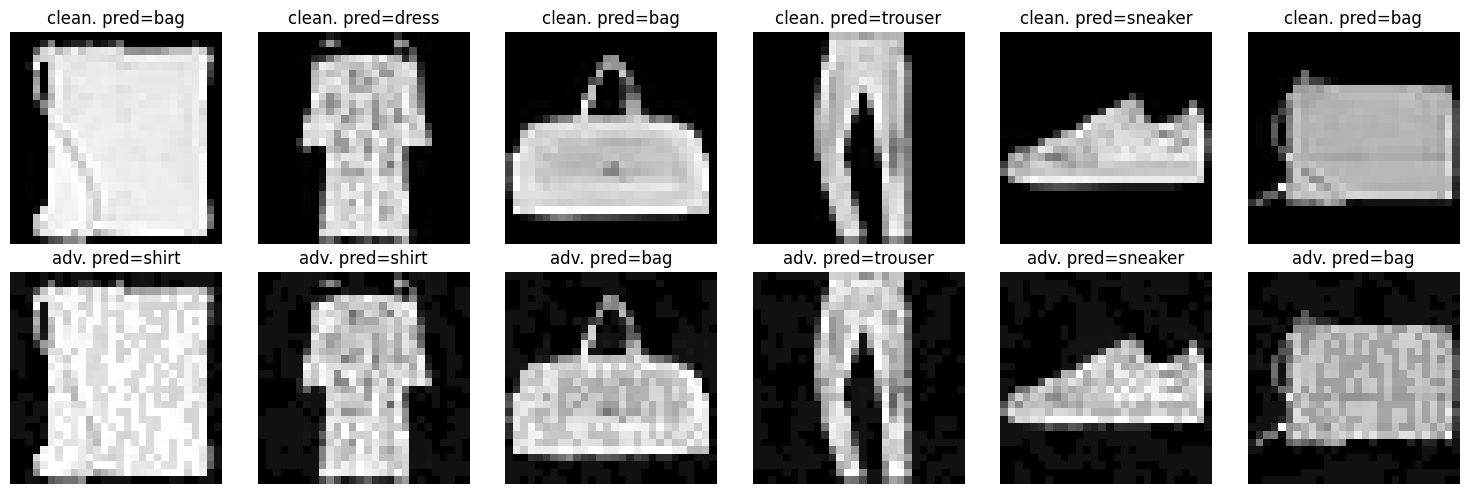

In [ ]:
classes = ["t-shirt", "trouser","pullover","dress","coat","sandal","shirt","sneaker","bag","boot"]
net = models.NetA().to(device)
net.load_state_dict(torch.load("netA_standard.pt"))
for data,labels in test_loader:
        data = data.to(device); labels = labels.to(device)

        ###
        # Compute and apply adversarial perturbation to data
        # eps between 0 and 0.2
        EPS= 0.07
        ITS=10
        ALP = 1.85*(EPS/ITS)

        ###
        adv_data = attacks.FGSM_attack(net,device,data.clone().detach(),labels,EPS)
        # Compute preds
        with torch.no_grad():
            clean_outputs = net(data)
            _,clean_preds = clean_outputs.max(1)
            clean_preds = clean_preds.cpu().squeeze().numpy()
            adv_outputs = net(adv_data)
            _,adv_preds = adv_outputs.max(1)
            adv_preds = adv_preds.cpu().squeeze().numpy()

        # Plot some samples
        inds = random.sample(list(range(data.size(0))),6)
        plt.figure(figsize=(15,5))
        for jj in range(6):
            plt.subplot(2,6,jj+1);plt.imshow(data[inds[jj],0].cpu().numpy(),cmap='gray');plt.axis("off");
            plt.title("clean. pred={}".format(classes[clean_preds[inds[jj]]]))
        for jj in range(6):
            plt.subplot(2,6,6+jj+1);plt.imshow(adv_data[inds[jj],0].cpu().numpy(),cmap='gray');plt.axis("off");
            plt.title("adv. pred={}".format(classes[adv_preds[inds[jj]]]))
        plt.tight_layout()
        plt.show()
        break

### rFGSM

<ipython-input-8-cee03e31d3b1>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load("netA_standard.pt"))


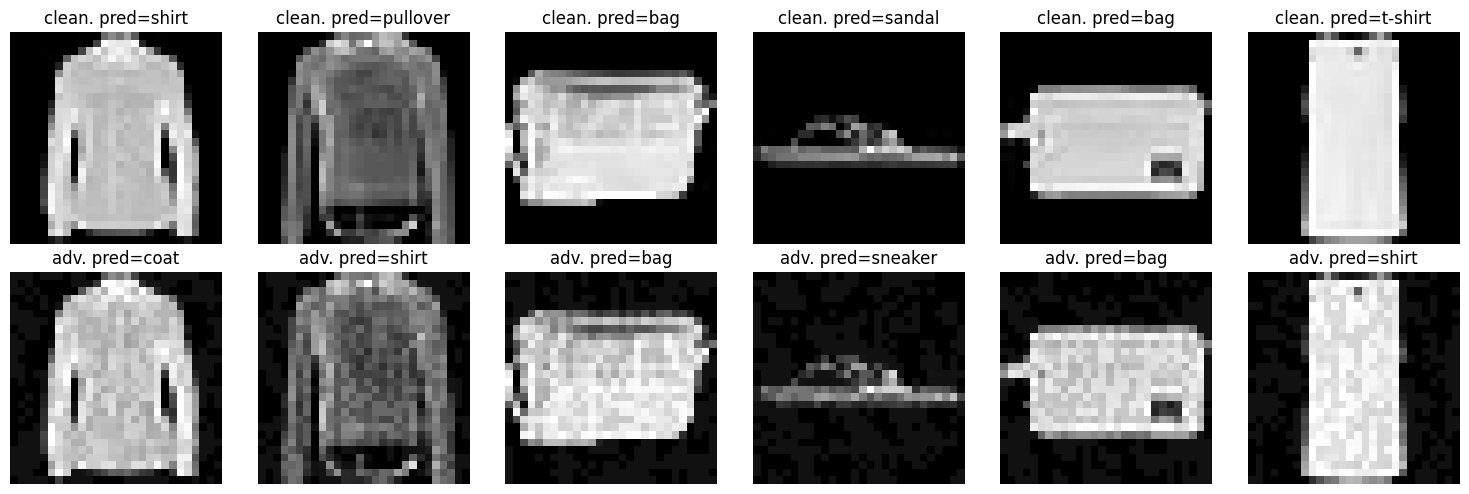

In [ ]:
classes = ["t-shirt", "trouser","pullover","dress","coat","sandal","shirt","sneaker","bag","boot"]
net = models.NetA().to(device)
net.load_state_dict(torch.load("netA_standard.pt"))
for data,labels in test_loader:
        data = data.to(device); labels = labels.to(device)

        ###
        # Compute and apply adversarial perturbation to data
        # eps between 0 and 0.2
        EPS= 0.07
        ITS=10
        ALP = 1.85*(EPS/ITS)

        ###
        adv_data = attacks.rFGSM_attack(net,device,data.clone().detach(),labels,EPS)
        # Compute preds
        with torch.no_grad():
            clean_outputs = net(data)
            _,clean_preds = clean_outputs.max(1)
            clean_preds = clean_preds.cpu().squeeze().numpy()
            adv_outputs = net(adv_data)
            _,adv_preds = adv_outputs.max(1)
            adv_preds = adv_preds.cpu().squeeze().numpy()

        # Plot some samples
        inds = random.sample(list(range(data.size(0))),6)
        plt.figure(figsize=(15,5))
        for jj in range(6):
            plt.subplot(2,6,jj+1);plt.imshow(data[inds[jj],0].cpu().numpy(),cmap='gray');plt.axis("off");
            plt.title("clean. pred={}".format(classes[clean_preds[inds[jj]]]))
        for jj in range(6):
            plt.subplot(2,6,6+jj+1);plt.imshow(adv_data[inds[jj],0].cpu().numpy(),cmap='gray');plt.axis("off");
            plt.title("adv. pred={}".format(classes[adv_preds[inds[jj]]]))
        plt.tight_layout()
        plt.show()
        break

FGSM L2

<ipython-input-17-0daf6d88e01b>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load("netA_standard.pt"))


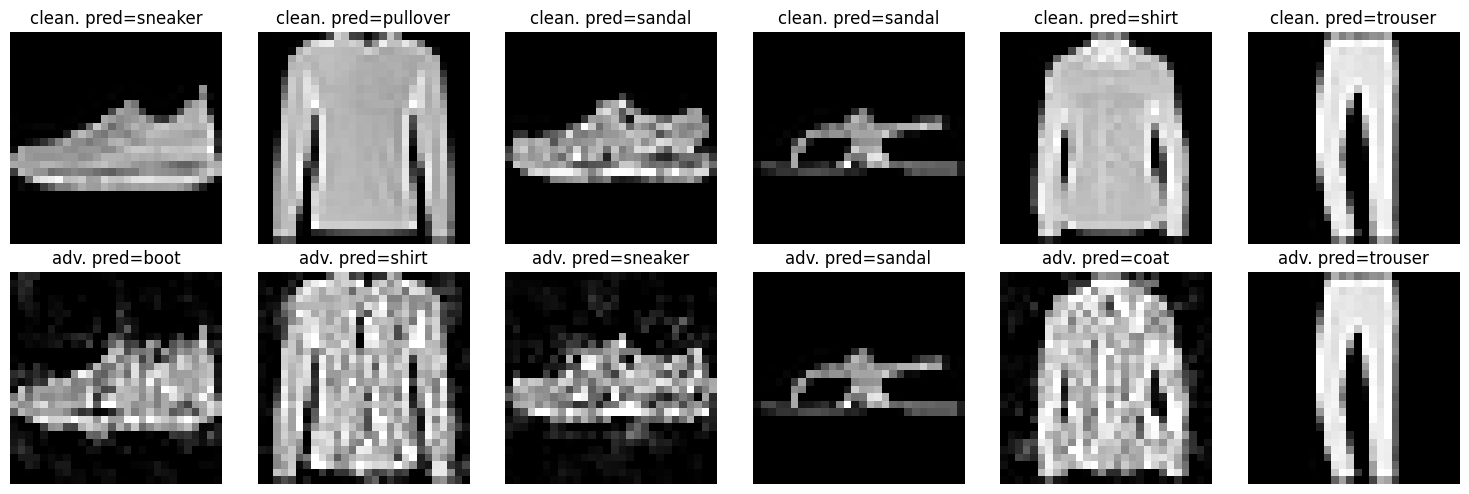

In [ ]:
classes = ["t-shirt", "trouser","pullover","dress","coat","sandal","shirt","sneaker","bag","boot"]
net = models.NetA().to(device)
net.load_state_dict(torch.load("netA_standard.pt"))
for data,labels in test_loader:
        data = data.to(device); labels = labels.to(device)

        ###
        # Compute and apply adversarial perturbation to data
        # eps between 0 and 0.2
        EPS= 4
        ITS=10
        ALP = 1.85*(EPS/ITS)

        ###
        adv_data = attacks.FGM_L2_attack(net,device,data.clone().detach(),labels,EPS)
        # Compute preds
        with torch.no_grad():
            clean_outputs = net(data)
            _,clean_preds = clean_outputs.max(1)
            clean_preds = clean_preds.cpu().squeeze().numpy()
            adv_outputs = net(adv_data)
            _,adv_preds = adv_outputs.max(1)
            adv_preds = adv_preds.cpu().squeeze().numpy()

        # Plot some samples
        inds = random.sample(list(range(data.size(0))),6)
        plt.figure(figsize=(15,5))
        for jj in range(6):
            plt.subplot(2,6,jj+1);plt.imshow(data[inds[jj],0].cpu().numpy(),cmap='gray');plt.axis("off");
            plt.title("clean. pred={}".format(classes[clean_preds[inds[jj]]]))
        for jj in range(6):
            plt.subplot(2,6,6+jj+1);plt.imshow(adv_data[inds[jj],0].cpu().numpy(),cmap='gray');plt.axis("off");
            plt.title("adv. pred={}".format(classes[adv_preds[inds[jj]]]))
        plt.tight_layout()
        plt.show()
        break

## Test Attacks - Whitebox & Blackbox

Don't forget to plot accuracy vs. epsilon curves!

In [10]:
## Load pretrained models
whitebox = models.NetA()
blackbox = models.NetB()

whitebox.load_state_dict(torch.load('netA_standard.pt')) # TODO
blackbox.load_state_dict(torch.load('netB_standard.pt')) # TODO

whitebox = whitebox.to(device); blackbox = blackbox.to(device)
whitebox.eval(); blackbox.eval()

test_acc,_ = test_model(whitebox,test_loader,device)
print("Initial Accuracy of Whitebox Model: ",test_acc)
test_acc,_ = test_model(blackbox,test_loader,device)
print("Initial Accuracy of Blackbox Model: ",test_acc)


print("Done!")

<ipython-input-10-f334e1d5158e>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  whitebox.load_state_dict(torch.load('netA_standard.pt')) # TODO
<ipython-input-10-f334e1d515

Initial Accuracy of Whitebox Model:  0.9234
Initial Accuracy of Blackbox Model:  0.9252
Done!


In [37]:
def test_attack(ATK_EPS,ATK_ITERS,ATK_ALPHA,white_model=whitebox,black_model=blackbox,attack_type = 0,verbose=False):
  whitebox_correct = 0.
  blackbox_correct = 0.
  running_total = 0.
  for batch_idx,(data,labels) in enumerate(test_loader):
      data = data.to(device)
      labels = labels.to(device)

      # TODO: Perform adversarial attack here
      if attack_type == 0:
        adv_data = attacks.random_noise_attack(whitebox,device,data.clone().detach(),ATK_EPS)
      elif attack_type == 1:
        adv_data = attacks.PGD_attack(whitebox,device,data.clone().detach(),labels,ATK_EPS,ATK_ALPHA,ATK_ITERS,rand_start=False)
      elif attack_type == 2:
        adv_data = attacks.FGSM_attack(whitebox,device,data.clone().detach(),labels,ATK_EPS)
      elif attack_type == 3:
        adv_data = attacks.rFGSM_attack(whitebox,device,data.clone().detach(),labels,ATK_EPS)
      # Sanity checking if adversarial example is "legal"
      assert(torch.max(torch.abs(adv_data-data)) <= (ATK_EPS + 1e-5) )
      assert(adv_data.max() == 1.)
      assert(adv_data.min() == 0.)

      # Compute accuracy on perturbed data
      with torch.no_grad():
          # Stat keeping - whitebox
          whitebox_outputs = whitebox(adv_data)
          _,whitebox_preds = whitebox_outputs.max(1)
          whitebox_correct += whitebox_preds.eq(labels).sum().item()
          # Stat keeping - blackbox
          blackbox_outputs = blackbox(adv_data)
          _,blackbox_preds = blackbox_outputs.max(1)
          blackbox_correct += blackbox_preds.eq(labels).sum().item()
          running_total += labels.size(0)

      # Plot some samples
      # if batch_idx == 1:
      #     plt.figure(figsize=(15,5))
      #     for jj in range(12):
      #         plt.subplot(2,6,jj+1);plt.imshow(adv_data[jj,0].cpu().numpy(),cmap='gray');plt.axis("off")
      #     plt.tight_layout()
      #     plt.show()

  # Print final
  whitebox_acc = whitebox_correct/running_total
  blackbox_acc = blackbox_correct/running_total

  if verbose:
    print("Attack Epsilon: {}; Whitebox Accuracy: {}; Blackbox Accuracy: {}".format(ATK_EPS, whitebox_acc, blackbox_acc))
  return whitebox_acc,blackbox_acc

In [59]:
def plot_accuracy(white_acc_list: list, black_acc_list: list, eps: list, labels: list):
    """
    Plots accuracy vs. epsilon curves for multiple attacks on the same plot.

    Args:
        white_acc_list: A list of lists, where each sublist contains the whitebox accuracy for an attack.
        black_acc_list: A list of lists, where each sublist contains the blackbox accuracy for an attack.
        eps: A list of epsilon values.
        labels: A list of labels for each attack.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))  # 1 row, 2 columns

    # Plot whitebox accuracy
    for white_acc, label in zip(white_acc_list, labels):
        ax1.plot(eps, white_acc, label=label)
    ax1.set_xlabel("Epsilon")
    ax1.set_ylabel("Accuracy")
    ax1.set_title("Whitebox Accuracy")
    ax1.legend()
    ax1.set_ylim([0,1])

    # Plot blackbox accuracy
    for black_acc, label in zip(black_acc_list, labels):
        ax2.plot(eps, black_acc, label=label)
    ax2.set_xlabel("Epsilon")
    ax2.set_ylabel("Accuracy")
    ax2.set_title("Blackbox Accuracy")
    ax2.legend()
    ax2.set_ylim([0,1])

    plt.tight_layout()
    plt.show()


## Random Noise Attack

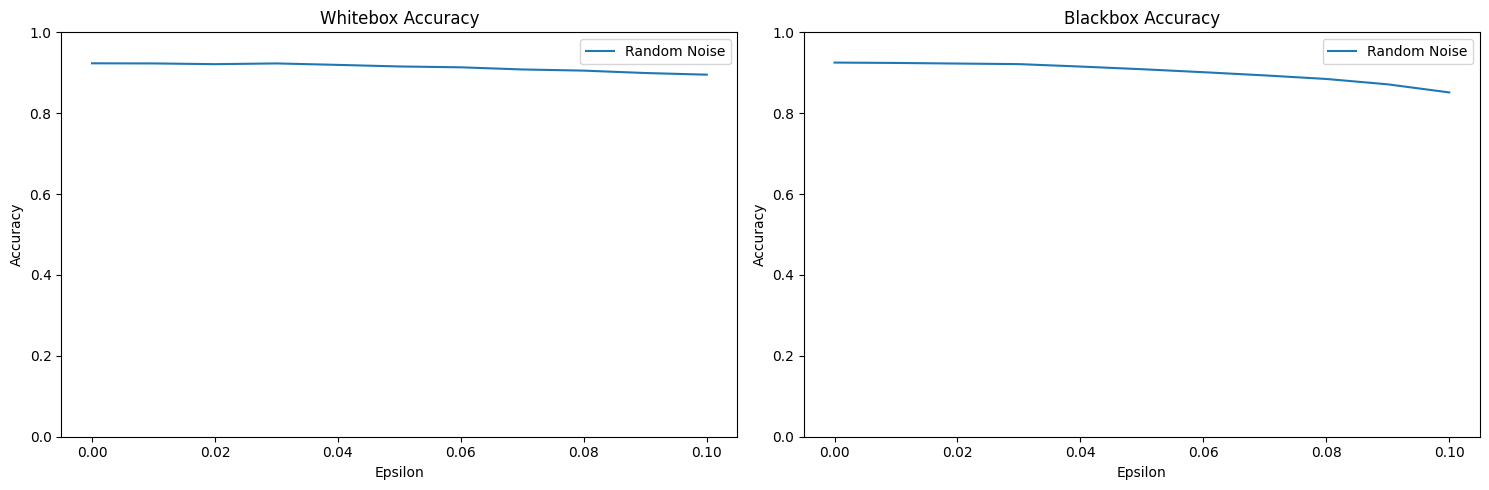

In [60]:
## Test the models against an adversarial attack

# TODO: Set attack parameters here
ATK_EPS = np.linspace(0,0.1,11)
ATK_ITERS = 10

whitebox_accuracy = []
blackbox_accuracy = []
for eps in ATK_EPS:
  ATK_ALPHA = 1.85*(eps/ATK_ITERS)
  white_acc,black_acc = test_attack(eps,ATK_ITERS,ATK_ALPHA,whitebox,blackbox)
  whitebox_accuracy.append(white_acc)
  blackbox_accuracy.append(black_acc)

eps_list = list(ATK_EPS)
label_list = ['Random Noise']
plot_accuracy([whitebox_accuracy],[blackbox_accuracy],eps_list,label_list)


In [47]:
## Test the models against an adversarial attack

# TODO: Set attack parameters here
ATK_EPS = np.linspace(0,0.1,11)
ATK_ITERS = 10

whitebox_random_accuracy = []
blackbox_random_accuracy = []

whitebox_pgd_accuracy = []
blackbox_pgd_accuracy = []

whitebox_fgsm_accuracy = []
blackbox_fgsm_accuracy = []

whitebox_rfgsm_accuracy = []
blackbox_rfgsm_accuracy = []

for eps in ATK_EPS:
  ATK_ALPHA = 1.85*(eps/ATK_ITERS)

  white_acc,black_acc = test_attack(eps,ATK_ITERS,ATK_ALPHA,whitebox,blackbox)

  white_pgd_acc,black_pgd_acc = test_attack(eps,ATK_ITERS,ATK_ALPHA,whitebox,blackbox,1)

  white_fgsm_acc,black_fgsm_acc = test_attack(eps,ATK_ITERS,ATK_ALPHA,whitebox,blackbox,2)

  white_rfgsm_acc,black_rfgsm_acc = test_attack(eps,ATK_ITERS,ATK_ALPHA,whitebox,blackbox,3)

  print(f"Appending white acc: {white_acc},and black acc: {black_acc}")
  whitebox_random_accuracy.append(white_acc)
  blackbox_random_accuracy.append(black_acc)

  whitebox_pgd_accuracy.append(white_pgd_acc)
  blackbox_pgd_accuracy.append(black_pgd_acc)

  whitebox_fgsm_accuracy.append(white_fgsm_acc)
  blackbox_fgsm_accuracy.append(black_fgsm_acc)

  whitebox_rfgsm_accuracy.append(white_rfgsm_acc)
  blackbox_rfgsm_accuracy.append(black_rfgsm_acc)



Appending white acc: 0.9234,and black acc: 0.9252
Appending white acc: 0.9239,and black acc: 0.925
Appending white acc: 0.922,and black acc: 0.9223
Appending white acc: 0.92,and black acc: 0.9202
Appending white acc: 0.9199,and black acc: 0.914
Appending white acc: 0.9172,and black acc: 0.9085
Appending white acc: 0.9129,and black acc: 0.9043
Appending white acc: 0.9131,and black acc: 0.8935
Appending white acc: 0.906,and black acc: 0.8854
Appending white acc: 0.8988,and black acc: 0.8702
Appending white acc: 0.8946,and black acc: 0.8556


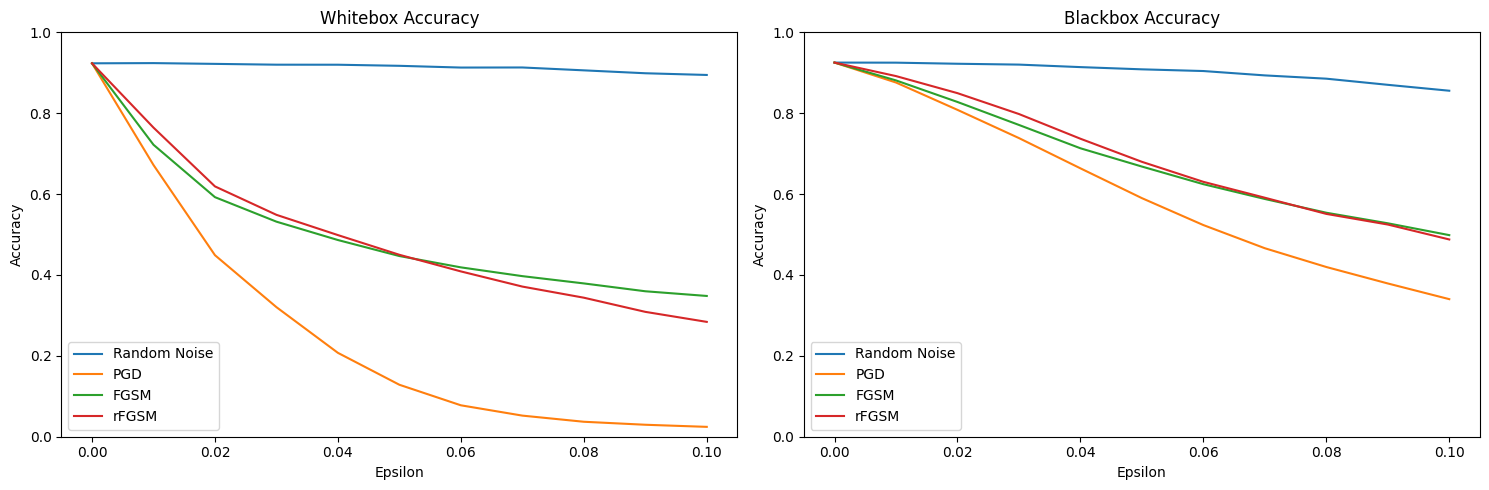

In [61]:

eps_list = list(ATK_EPS)
white_list = [whitebox_random_accuracy,whitebox_pgd_accuracy,whitebox_fgsm_accuracy,whitebox_rfgsm_accuracy]
black_list = [blackbox_random_accuracy,blackbox_pgd_accuracy,blackbox_fgsm_accuracy,blackbox_rfgsm_accuracy]
label_list = ['Random Noise','PGD','FGSM','rFGSM']
plot_accuracy(white_list,black_list,eps_list,label_list)

## Test Robust Models

Don't forget to plot accuracy vs. epsilon curves!

## FGSM Trained

In [69]:
whitebox = models.NetA()
whitebox.load_state_dict(torch.load('netA_advtrain_fgsm0p1.pt')) # TODO: Load your robust models
whitebox = whitebox.to(device)
whitebox.eval();

test_acc,_ = test_model(whitebox,test_loader,device)
print("Initial Accuracy of Whitebox Model: ",test_acc)


<ipython-input-69-4d81b6f9bac7>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  whitebox.load_state_dict(torch.load('netA_advtrain_fgsm0p1.pt')) # TODO: Load your robust mo

Initial Accuracy of Whitebox Model:  0.9271


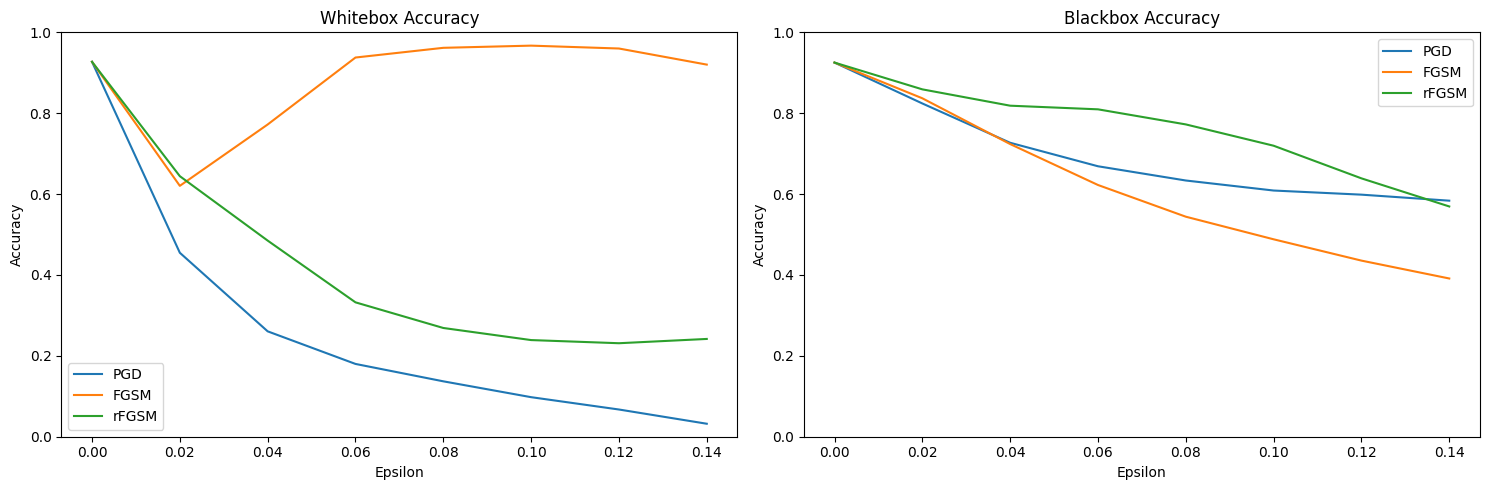

In [73]:
## Test the models against an adversarial attack

# TODO: Set attack parameters here
ATK_EPS = np.linspace(0, 0.14, num=int(0.14 / 0.02) + 1)
ATK_ITERS = 10

whitebox_pgd_accuracy = []
blackbox_pgd_accuracy = []

whitebox_fgsm_accuracy = []
blackbox_fgsm_accuracy = []

whitebox_rfgsm_accuracy = []
blackbox_rfgsm_accuracy = []

for eps in ATK_EPS:
  ATK_ALPHA = 1.85*(eps/ATK_ITERS)

  white_pgd_acc,black_pgd_acc = test_attack(eps,ATK_ITERS,ATK_ALPHA,whitebox,blackbox,1)

  white_fgsm_acc,black_fgsm_acc = test_attack(eps,ATK_ITERS,ATK_ALPHA,whitebox,blackbox,2)

  white_rfgsm_acc,black_rfgsm_acc = test_attack(eps,ATK_ITERS,ATK_ALPHA,whitebox,blackbox,3)

  whitebox_pgd_accuracy.append(white_pgd_acc)
  blackbox_pgd_accuracy.append(black_pgd_acc)

  whitebox_fgsm_accuracy.append(white_fgsm_acc)
  blackbox_fgsm_accuracy.append(black_fgsm_acc)

  whitebox_rfgsm_accuracy.append(white_rfgsm_acc)
  blackbox_rfgsm_accuracy.append(black_rfgsm_acc)

eps_list = list(ATK_EPS)
white_list = [whitebox_pgd_accuracy,whitebox_fgsm_accuracy,whitebox_rfgsm_accuracy]
black_list = [blackbox_pgd_accuracy,blackbox_fgsm_accuracy,blackbox_rfgsm_accuracy]
label_list = ['PGD','FGSM','rFGSM']
plot_accuracy(white_list,black_list,eps_list,label_list)

In [74]:
whitebox = models.NetA()
whitebox.load_state_dict(torch.load('netA_advtrain_rfgsm0p1.pt')) # TODO: Load your robust models
whitebox = whitebox.to(device)
whitebox.eval();

test_acc,_ = test_model(whitebox,test_loader,device)
print("Initial Accuracy of Whitebox Model: ",test_acc)

<ipython-input-74-286336ea4fac>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  whitebox.load_state_dict(torch.load('netA_advtrain_rfgsm0p1.pt')) # TODO: Load your robust m

Initial Accuracy of Whitebox Model:  0.9148


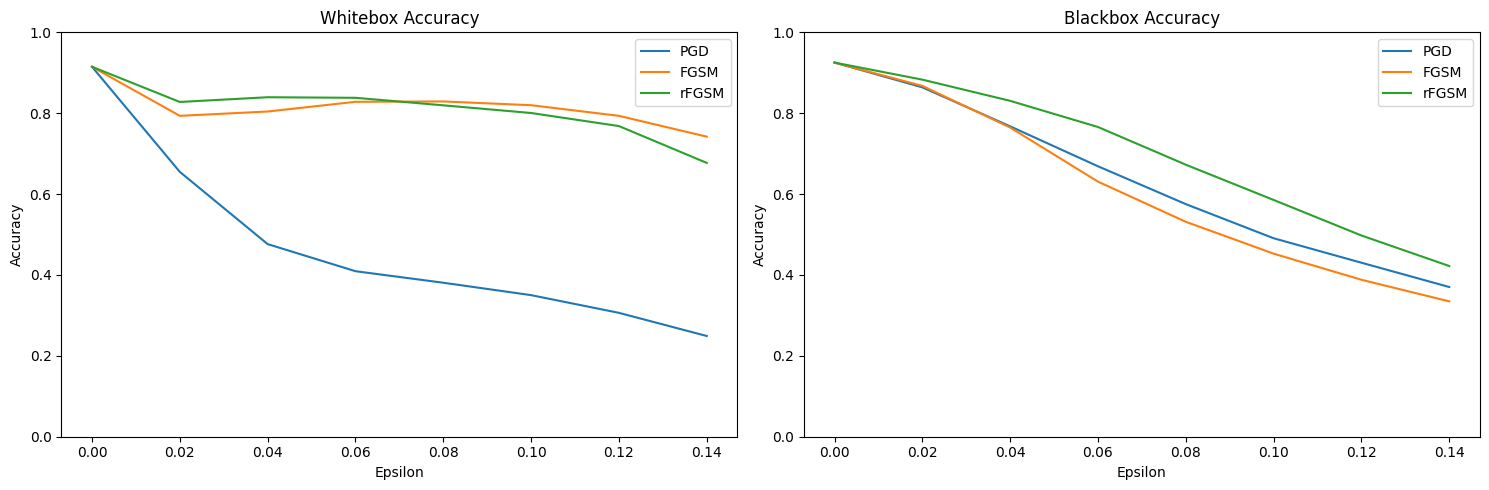

In [75]:
## Test the models against an adversarial attack

# TODO: Set attack parameters here
ATK_EPS = np.linspace(0, 0.14, num=int(0.14 / 0.02) + 1)
ATK_ITERS = 10

whitebox_pgd_accuracy = []
blackbox_pgd_accuracy = []

whitebox_fgsm_accuracy = []
blackbox_fgsm_accuracy = []

whitebox_rfgsm_accuracy = []
blackbox_rfgsm_accuracy = []

for eps in ATK_EPS:
  ATK_ALPHA = 1.85*(eps/ATK_ITERS)

  white_pgd_acc,black_pgd_acc = test_attack(eps,ATK_ITERS,ATK_ALPHA,whitebox,blackbox,1)

  white_fgsm_acc,black_fgsm_acc = test_attack(eps,ATK_ITERS,ATK_ALPHA,whitebox,blackbox,2)

  white_rfgsm_acc,black_rfgsm_acc = test_attack(eps,ATK_ITERS,ATK_ALPHA,whitebox,blackbox,3)

  whitebox_pgd_accuracy.append(white_pgd_acc)
  blackbox_pgd_accuracy.append(black_pgd_acc)

  whitebox_fgsm_accuracy.append(white_fgsm_acc)
  blackbox_fgsm_accuracy.append(black_fgsm_acc)

  whitebox_rfgsm_accuracy.append(white_rfgsm_acc)
  blackbox_rfgsm_accuracy.append(black_rfgsm_acc)

eps_list = list(ATK_EPS)
white_list = [whitebox_pgd_accuracy,whitebox_fgsm_accuracy,whitebox_rfgsm_accuracy]
black_list = [blackbox_pgd_accuracy,blackbox_fgsm_accuracy,blackbox_rfgsm_accuracy]
label_list = ['PGD','FGSM','rFGSM']
plot_accuracy(white_list,black_list,eps_list,label_list)

In [76]:
whitebox = models.NetA()
whitebox.load_state_dict(torch.load('netA_advtrain_pgd0p1.pt')) # TODO: Load your robust models
whitebox = whitebox.to(device)
whitebox.eval();

test_acc,_ = test_model(whitebox,test_loader,device)
print("Initial Accuracy of Whitebox Model: ",test_acc)

<ipython-input-76-1fa3db291864>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  whitebox.load_state_dict(torch.load('netA_advtrain_pgd0p1.pt')) # TODO: Load your robust mod

Initial Accuracy of Whitebox Model:  0.8885


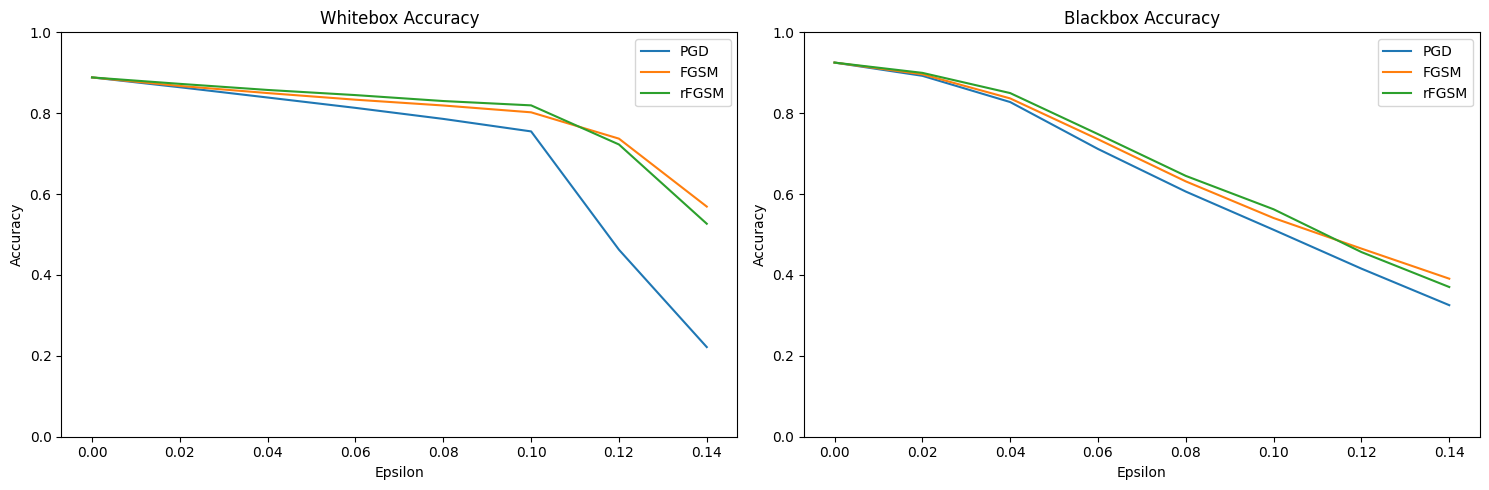

In [77]:
## Test the models against an adversarial attack

# TODO: Set attack parameters here
ATK_EPS = np.linspace(0, 0.14, num=int(0.14 / 0.02) + 1)
ATK_ITERS = 10

whitebox_pgd_accuracy = []
blackbox_pgd_accuracy = []

whitebox_fgsm_accuracy = []
blackbox_fgsm_accuracy = []

whitebox_rfgsm_accuracy = []
blackbox_rfgsm_accuracy = []

for eps in ATK_EPS:
  ATK_ALPHA = 1.85*(eps/ATK_ITERS)

  white_pgd_acc,black_pgd_acc = test_attack(eps,ATK_ITERS,ATK_ALPHA,whitebox,blackbox,1)

  white_fgsm_acc,black_fgsm_acc = test_attack(eps,ATK_ITERS,ATK_ALPHA,whitebox,blackbox,2)

  white_rfgsm_acc,black_rfgsm_acc = test_attack(eps,ATK_ITERS,ATK_ALPHA,whitebox,blackbox,3)

  whitebox_pgd_accuracy.append(white_pgd_acc)
  blackbox_pgd_accuracy.append(black_pgd_acc)

  whitebox_fgsm_accuracy.append(white_fgsm_acc)
  blackbox_fgsm_accuracy.append(black_fgsm_acc)

  whitebox_rfgsm_accuracy.append(white_rfgsm_acc)
  blackbox_rfgsm_accuracy.append(black_rfgsm_acc)

eps_list = list(ATK_EPS)
white_list = [whitebox_pgd_accuracy,whitebox_fgsm_accuracy,whitebox_rfgsm_accuracy]
black_list = [blackbox_pgd_accuracy,blackbox_fgsm_accuracy,blackbox_rfgsm_accuracy]
label_list = ['PGD','FGSM','rFGSM']
plot_accuracy(white_list,black_list,eps_list,label_list)